In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [20]:
# declare path
train_dir = 'C:/Users/Nikitha/Downloads/data/train/'
test_dir = 'C:/Users/Nikitha/Downloads/data/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10



In [21]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [22]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [24]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


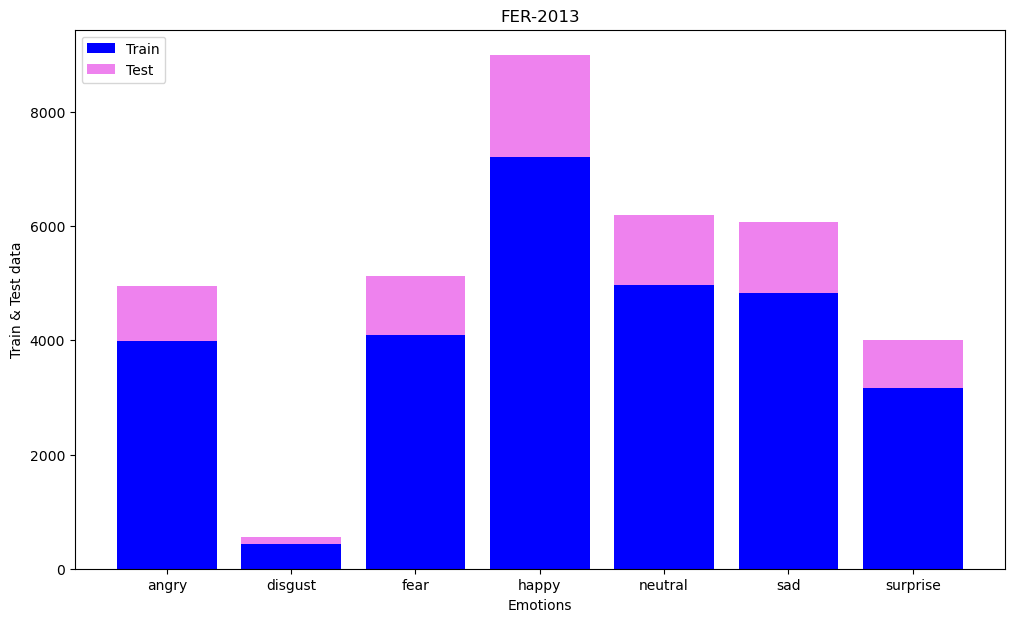

In [25]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()


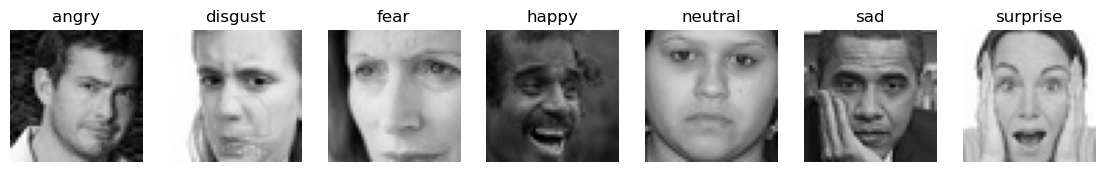

In [26]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [27]:
base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [28]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False

In [30]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [32]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [33]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

Epoch 1/100
449/449 [==============================] - 789s 2s/step - loss: 5.3316 - accuracy: 0.8163 - precision: 0.2063 - recall: 0.1005 - auc: 0.5514 - f1_score: 0.1350 - val_loss: 3.6470 - val_accuracy: 0.8193 - val_precision: 0.2995 - val_recall: 0.1980 - val_auc: 0.6301 - val_f1_score: 0.2397 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - 580s 1s/step - loss: 4.7168 - accuracy: 0.8294 - precision: 0.2810 - recall: 0.1248 - auc: 0.6093 - f1_score: 0.1720 - val_loss: 13.6796 - val_accuracy: 0.7474 - val_precision: 0.1157 - val_recall: 0.1156 - val_auc: 0.4536 - val_f1_score: 0.1148 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - 560s 1s/step - loss: 4.2697 - accuracy: 0.8394 - precision: 0.3453 - recall: 0.1387 - auc: 0.6416 - f1_score: 0.1975 - val_loss: 3.4054 - val_accuracy: 0.8283 - val_precision: 0.2116 - val_recall: 0.0740 - val_auc: 0.5277 - val_f1_score: 0.1083 - lr: 1.0000e-04
Epoch 4/100
449/449 [===========================

Epoch 27/100
449/449 [==============================] - 559s 1s/step - loss: 1.7638 - accuracy: 0.9065 - precision: 0.7563 - recall: 0.5100 - auc: 0.9184 - f1_score: 0.6087 - val_loss: 1.2541 - val_accuracy: 0.8993 - val_precision: 0.7222 - val_recall: 0.4795 - val_auc: 0.9013 - val_f1_score: 0.5763 - lr: 1.0000e-04
Epoch 28/100
449/449 [==============================] - 701s 2s/step - loss: 1.7258 - accuracy: 0.9080 - precision: 0.7591 - recall: 0.5216 - auc: 0.9215 - f1_score: 0.6176 - val_loss: 1.2452 - val_accuracy: 0.9005 - val_precision: 0.7095 - val_recall: 0.5135 - val_auc: 0.9042 - val_f1_score: 0.5963 - lr: 1.0000e-04
Epoch 29/100
449/449 [==============================] - 709s 2s/step - loss: 1.6462 - accuracy: 0.9118 - precision: 0.7692 - recall: 0.5468 - auc: 0.9274 - f1_score: 0.6383 - val_loss: 1.3675 - val_accuracy: 0.8940 - val_precision: 0.6749 - val_recall: 0.4983 - val_auc: 0.8860 - val_f1_score: 0.5728 - lr: 1.0000e-04
Epoch 30/100
449/449 [========================

449/449 [==============================] - 563s 1s/step - loss: 0.6618 - accuracy: 0.9660 - precision: 0.9000 - recall: 0.8570 - auc: 0.9869 - f1_score: 0.8778 - val_loss: 1.4105 - val_accuracy: 0.8997 - val_precision: 0.6584 - val_recall: 0.6187 - val_auc: 0.8993 - val_f1_score: 0.6376 - lr: 5.0000e-05
Epoch 53/100
449/449 [==============================] - 556s 1s/step - loss: 0.6515 - accuracy: 0.9672 - precision: 0.9031 - recall: 0.8631 - auc: 0.9866 - f1_score: 0.8826 - val_loss: 1.4428 - val_accuracy: 0.8983 - val_precision: 0.6544 - val_recall: 0.6109 - val_auc: 0.8967 - val_f1_score: 0.6300 - lr: 5.0000e-05
Epoch 54/100
449/449 [==============================] - 553s 1s/step - loss: 0.6334 - accuracy: 0.9674 - precision: 0.9035 - recall: 0.8645 - auc: 0.9878 - f1_score: 0.8834 - val_loss: 1.4295 - val_accuracy: 0.9006 - val_precision: 0.6621 - val_recall: 0.6216 - val_auc: 0.8994 - val_f1_score: 0.6409 - lr: 5.0000e-05
Epoch 55/100
449/449 [==============================] - 556

In [34]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 57s 500ms/step - loss: 1.4190 - accuracy: 0.9030 - precision: 0.6705 - recall: 0.6318 - auc: 0.9004 - f1_score: 0.6518


metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))

In [36]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 [==============================] - 52s 454ms/step


In [37]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk
